In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
TSLA = pdr.get_data_yahoo('TSLA')
day = np.arange(1,len(TSLA) + 1)

In [3]:
TSLA['day'] = day
TSLA = TSLA[['day','Open', 'High', 'Low','Close']]

In [4]:
TSLA.head()

,day,Open,High,Low,Close
Date,,,,,
2017-09-05,1,23.586666,23.699333,23.059334,23.306000
2017-09-06,2,23.299999,23.398666,22.770666,22.968666
2017-09-07,3,23.065332,23.498667,22.896667,23.374001
2017-09-08,4,23.266001,23.318666,22.820000,22.893333
2017-09-11,5,23.423332,24.247334,23.333332,24.246000


# Adding moving average to the dataframe

Signal creation => 
- Using moving average
- 2 moving averages: Slow and Fast
- Enter a trade when the fast MA goes above slow MA
- Clear the position and go short when fast goes below slow MA

In [5]:
TSLA['9-day'] = TSLA['Close'].rolling(9).mean().shift()
TSLA['21-day'] = TSLA['Close'].rolling(21).mean().shift()
#currently has look ahead information
#now lookahead is gone since we used the shift()


In [6]:
TSLA[19:25]

,day,Open,High,Low,Close,9-day,21-day
Date,,,,,,,
2017-10-02,20,22.834667,22.913334,22.367332,22.768667,23.544370,NaN
2017-10-03,21,22.393333,23.236668,22.085333,23.209333,23.295703,NaN
2017-10-04,22,23.416668,23.908001,23.306667,23.667334,23.104815,23.782254
2017-10-05,23,23.733334,23.829332,23.423332,23.688667,23.019852,23.799460
2017-10-06,24,23.540001,24.006666,23.483334,23.792000,23.051259,23.833746
2017-10-09,25,23.309999,23.450001,22.844667,22.862667,23.139333,23.853651


In [7]:
TSLA['signal'] = np.where(TSLA['9-day']>TSLA['21-day'],1,0)
TSLA['signal'] = np.where(TSLA['9-day']<TSLA['21-day'],-1,TSLA['signal'])
TSLA.dropna(inplace=True)

In [8]:
TSLA.tail()

,day,Open,High,Low,Close,9-day,21-day,signal
Date,,,,,,,,
2022-08-29,1255,282.829987,287.739990,280.700012,284.820007,297.524445,297.191748,1
2022-08-30,1256,287.869995,288.480011,272.649994,277.700012,295.108521,296.604606,-1
2022-08-31,1257,280.619995,281.250000,271.809998,275.609985,292.186669,295.672384,-1
2022-09-01,1258,272.579987,277.579987,266.149994,277.160004,289.157779,294.483018,-1
2022-09-02,1259,281.065002,282.350006,269.080994,270.209991,286.990373,293.043177,-1


# Returns

In [9]:
TSLA['returns'] = np.log(TSLA['Close']).diff()
TSLA['system_return'] = TSLA['signal'] * TSLA['returns']
TSLA['entry'] = TSLA.signal.diff()

In [10]:
TSLA.head()

,day,Open,High,Low,Close,9-day,21-day,signal,returns,system_return,entry
Date,,,,,,,,,,,
2017-10-04,22,23.416668,23.908001,23.306667,23.667334,23.104815,23.782254,-1,NaN,NaN,NaN
2017-10-05,23,23.733334,23.829332,23.423332,23.688667,23.019852,23.799460,-1,0.000901,-0.000901,0.0
2017-10-06,24,23.540001,24.006666,23.483334,23.792000,23.051259,23.833746,-1,0.004353,-0.004353,0.0
2017-10-09,25,23.309999,23.450001,22.844667,22.862667,23.139333,23.853651,-1,-0.039844,0.039844,0.0
2017-10-10,26,23.120001,23.708668,23.035334,23.705999,23.122222,23.852190,-1,0.036223,-0.036223,0.0


# Plot trades on time series

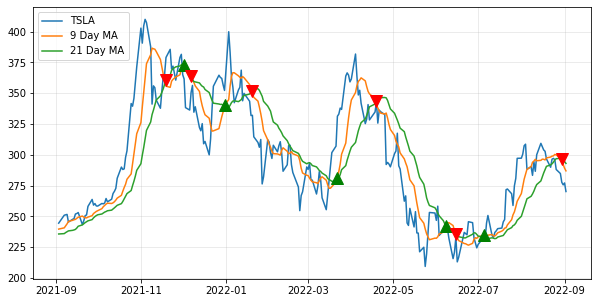

In [11]:
plt.rcParams['figure.figsize'] = 10,5
plt.grid(True, alpha = 0.3)
plt.plot(TSLA.iloc[-252:]['Close'],label = 'TSLA')
plt.plot(TSLA.iloc[-252:]['9-day'],label = '9 Day MA')
plt.plot(TSLA.iloc[-252:]['21-day'],label = '21 Day MA')
plt.plot(TSLA[-252:].loc[TSLA.entry == 2].index, TSLA[-252:]['9-day'][TSLA.entry == 2], '^', color = 'g', markersize = 12)
plt.plot(TSLA[-252:].loc[TSLA.entry == -2].index, TSLA[-252:]['21-day'][TSLA.entry == -2], 'v', color = 'r', markersize = 12)
plt.legend(loc=2)

# System vs Buy and Hold 

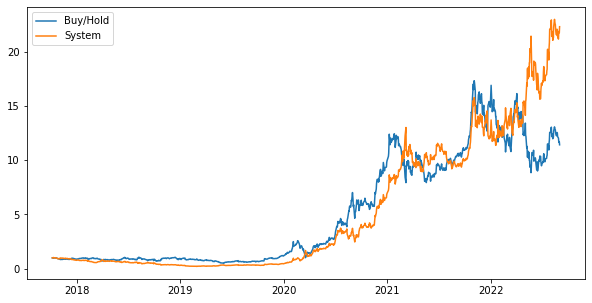

In [12]:
plt.plot(np.exp(TSLA['returns']).cumprod(),label='Buy/Hold')
plt.plot(np.exp(TSLA['system_return']).cumprod(),label='System')
plt.legend(loc=2)

In [13]:
np.exp(TSLA['returns']).cumprod()[-1] - 1

10.417001846879264

In [14]:
np.exp(TSLA['system_return']).cumprod()[-1] - 1

21.298087390136452

In [15]:
import pyfolio as pf

/Users/amaymahajan/opt/anaconda3/lib/python3.9/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2017-10-04
End date,2022-09-02
Total months,58
,Backtest
Annual return,53.1%
Cumulative returns,710.1%
Annual volatility,64.1%
Sharpe ratio,0.99
Calmar ratio,0.64
Stability,0.67
Max drawdown,-83.5%


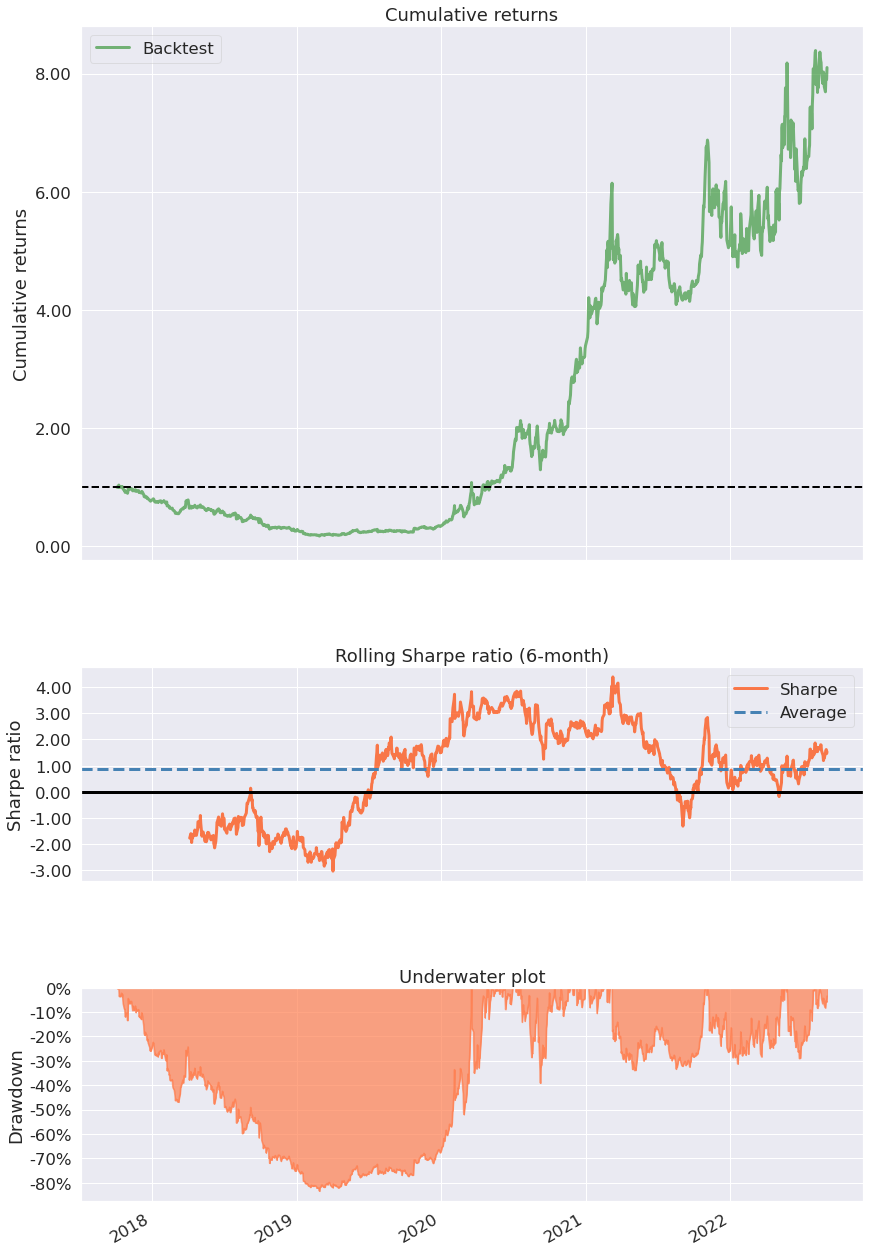

In [16]:
pf.create_simple_tear_sheet(TSLA['system_return'])

Start date,2017-10-04
End date,2022-09-02
Total months,58
,Backtest
Annual return,33.5%
Cumulative returns,313.2%
Annual volatility,64.1%
Sharpe ratio,0.77
Calmar ratio,0.52
Stability,0.73
Max drawdown,-63.9%


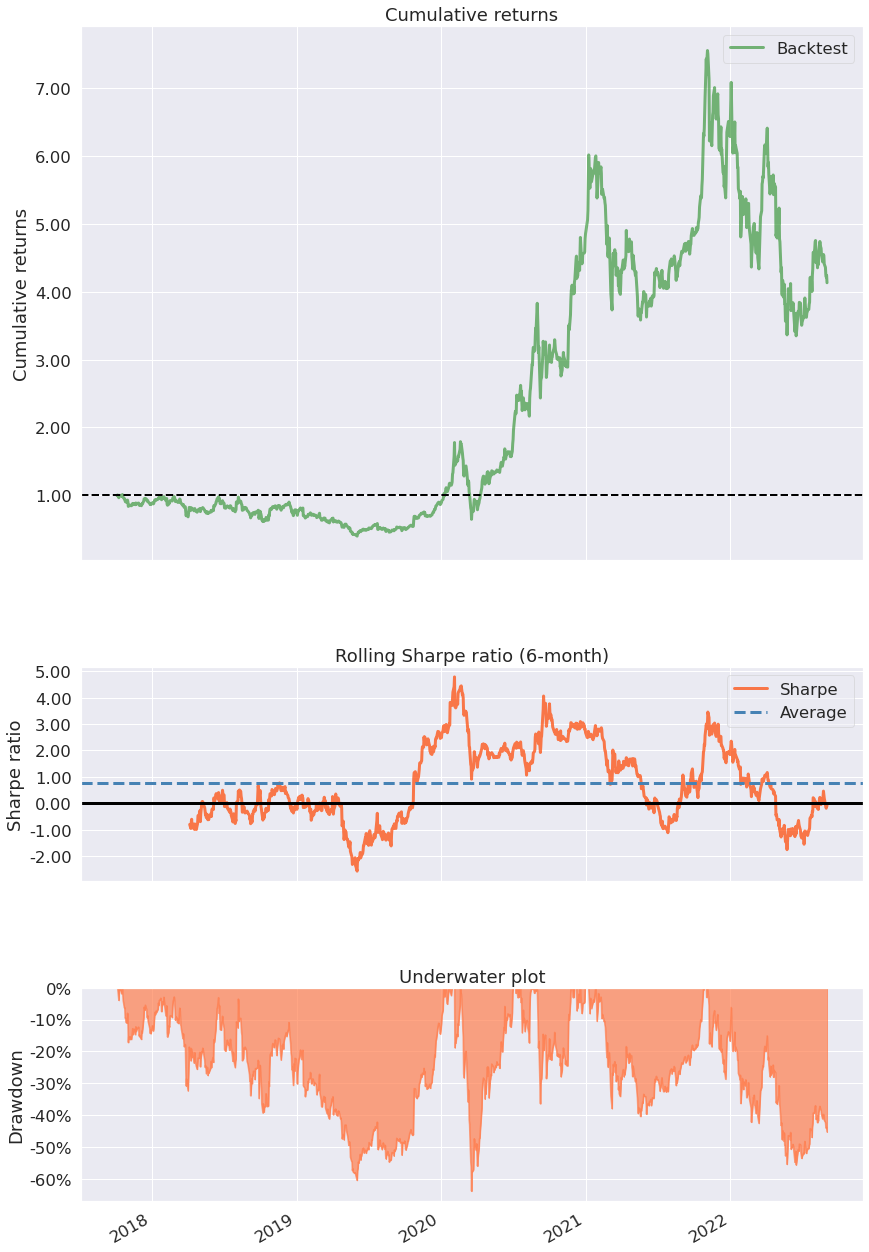

In [19]:
pf.create_simple_tear_sheet(TSLA['returns'])